## tspDB Running Example (Electricity Demand)
In this notebook, we showcase our tool functionalities on a real world timeseries 'demand'.

In particular, we show how a prediction index is created, how predictions are produced with uncertainity quantification, and how does the predictions and confidence interval compare visually with the observations and their underlining means.

To run this test, you need:

1- tspDB installed on a PostgreSQL Database

2- psycopg2, pandas and matplotlib packages installed




In [39]:
# Import the packages
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import io

Fill in your database connection information below

In [40]:
## fill your db information
database = 'querytime_test'
user = 'postgres'
password = '0505'
host = 'localhost'
conn_string = "host='%s' dbname='%s' user='%s' password='%s'" %(host, database, user, password)
conn = psycopg2.connect(conn_string)

### Create Table in DB

In [41]:
conn = psycopg2.connect(conn_string)

cur = conn.cursor()

# drop table id exists
cur.execute("DROP table IF EXISTS demand;")




In [42]:
# load and fix timestamp
df = pd.read_csv('coa_q_train.csv')
df['Time'] = pd.to_datetime(df['Time'], format = '%d/%m/%Y %H:%M')



In [43]:


# create and populate table
create_table = "CREATE  TABLE demand(\
   time timestamp PRIMARY KEY,\
   coa double precision);"
cur.execute(create_table)
print('Create Table')

output = io.StringIO()
df.to_csv(output, sep='\t', header=False, index=False)
output.seek(0)
cur.copy_from(output, 'demand', null="")

# close connection
conn.commit()
conn.close()

Create Table


### The time series table
Lets query our table mixturets2 to inspect its column 

In [44]:
conn = psycopg2.connect(conn_string)
# lets query our table mixturets2 to inspect its column 
df = pd.read_sql_query("select * from demand order by time limit 50;", conn)
df

time          coa
0  2012-01-01 00:15:00  6334.790000
1  2012-01-01 00:30:00  6221.730000
2  2012-01-01 00:45:00  6108.680000
3  2012-01-01 01:00:00  5995.630000
4  2012-01-01 01:15:00  5891.500000
5  2012-01-01 01:30:00  5790.270000
6  2012-01-01 01:45:00  5678.510000
7  2012-01-01 02:00:00  5588.660000
8  2012-01-01 02:15:00  5487.600000
9  2012-01-01 02:30:00  5613.940000
10 2012-01-01 02:45:00  5579.390000
11 2012-01-01 03:00:00  5544.840000
12 2012-01-01 03:15:00  5456.109047
13 2012-01-01 03:30:00  5418.552641
14 2012-01-01 03:45:00  5441.190000
15 2012-01-01 04:00:00  5406.640000
16 2012-01-01 04:15:00  5385.330000
17 2012-01-01 04:30:00  5400.560000
18 2012-01-01 04:45:00  5482.470000
19 2012-01-01 05:00:00  5583.010000
20 2012-01-01 05:15:00  5683.560000
21 2012-01-01 05:30:00  5789.950000
22 2012-01-01 05:45:00  5901.950000
23 2012-01-01 06:00:00  6013.950000
24 2012-01-01 06:15:00  6125.940000
25 2012-01-01 06:30:00  6112.580000
26 2012-01-01 06:45:00  6019.570000
27 2012-01-01 07:00:00  5926.570000
28 2012-01-01 07:15:00  5857.500000
29 2012-01-01 07:30:00  5855.620000
30 2012-01-01 07:45:00  5848.419299
31 2012-01-01 08:00:00  5851.860000
32 2012-01-01 08:15:00  5875.640000
33 2012-01-01 08:30:00  5887.570000
34 2012-01-01 08:45:00  5918.430000
35 2012-01-01 09:00:00  5980.700000
36 2012-01-01 09:15:00  5921.100000
37 2012-01-01 09:30:00  5994.790000
38 2012-01-01 09:45:00  6066.140000
39 2012-01-01 10:00:00  6089.740000
40 2012-01-01 10:15:00  6113.330000
41 2012-01-01 10:30:00  6136.930000
42 2012-01-01 10:45:00  6160.520000
43 2012-01-01 11:00:00  6184.120000
44 2012-01-01 11:15:00  6195.010000
45 2012-01-01 11:30:00  6199.840000
46 2012-01-01 11:45:00  6448.550000
47 2012-01-01 12:00:00  6178.540000
48 2012-01-01 12:15:00  6167.080000
49 2012-01-01 12:30:00  6190.340000

Our time series table consist of 2 columns, namely:

**1- time**: (timestamp) this column represent the time index 

**2- coa:** (float) Where the demand data is stored


Now, let's create a prediction index on column coa in our table.
### Create prediction index

First, let's list the prediction indices already created.

In [45]:
df = pd.read_sql_query("select * from list_pindices();", conn)
df

index_name value_columns         relation time_column  \
0           pindex_test         [coa]           demand        time   
1     mixturets2_pindex          [ts]       mixturets2        time   
2          basic_pindex          [ts]  ts_basic_ts_5_5        time   
3  mixturets_var_pindex          [ts]    mixturets_var        time   

     initial_timestamp       last_timestamp agg_interval  \
0  2012-01-01 00:15:00  2019-08-23 01:45:00     00:15:00   
1                    0               100001      1 units   
2  2012-10-01 00:00:00  2012-10-06 18:53:15     00:00:05   
3                    0               100001      1 units   

   uncertainty_quantification  
0                        True  
1                        True  
2                        True  
3                        True

Now, we will create a predictive index which we will call 'pindex_test' on the column coa 

In [46]:
conn.close()
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
cursor.execute(""" select create_pindex('demand', 'time','coa','pindex_test', agg_interval =>15*60,"T" => 10000,k => 25, "L" => 4*24);""")
conn.commit()
conn.close()

Now lets list our predictive indices 

In [47]:
conn = psycopg2.connect(conn_string)
df = pd.read_sql_query("select * from list_pindices();", conn)
df

index_name value_columns         relation time_column  \
0           pindex_test         [coa]           demand        time   
1     mixturets2_pindex          [ts]       mixturets2        time   
2          basic_pindex          [ts]  ts_basic_ts_5_5        time   
3  mixturets_var_pindex          [ts]    mixturets_var        time   

     initial_timestamp       last_timestamp agg_interval  \
0  2012-01-01 00:15:00  2019-08-20 23:45:00     00:15:00   
1                    0               100001      1 units   
2  2012-10-01 00:00:00  2012-10-06 18:53:15     00:00:05   
3                    0               100001      1 units   

   uncertainty_quantification  
0                        True  
1                        True  
2                        True  
3                        True

We see that our index has been created. Now lets list our predictive indices accuracies

In [48]:
df = pd.read_sql_query("select * from pindices_stat();", conn)
df

index_name  number_of_observations  number_of_trained_models  \
0  mixturets_var_pindex                  100001                        20   
1     mixturets2_pindex                  100001                         1   
2          basic_pindex                   99999                         1   
3           pindex_test                  267742                        53   

   imputation_score  forecast_score  
0          0.624626        0.634596  
1          0.990497        0.990547  
2          1.000000        1.000000  
3          0.999505        0.999194

### Prediction Queries
Let's now use the prediction function and range prediction function. Specifically, let's use 'pindex_test' to predict <em>coa</em> value at $time = $  2012-01-01 00:15:00 

In [49]:
df = pd.read_sql_query("select * from predict('demand','coa','2012-01-01 00:15:00'::timestamp,'pindex_test');", conn)
df

prediction           lb           ub
0  6311.646031  6295.450569  6327.841493

Additionaly, let's use **pindex_test** to predict **coa** value at the interval 2012-01-01 00:15:00 < t < 2012-01-02 00:15:00 .  
The **c** option lets you choose the confidence interval you want to use, let's try c= 80 in the code below. 

In [50]:
t1 = "'2012-01-01 00:15:00'::timestamp"
t2 = "'2012-01-10 00:15:00'::timestamp"
df = pd.read_sql_query("select * from predict_range('demand','coa',%s,%s,'pindex_test', c=> 80);"%(t1,t2), conn)
df

prediction           lb           ub
0    6311.646031  6301.056387  6322.235674
1    6220.962731  6212.860455  6229.065006
2    6111.284047  6100.773155  6121.794939
3    6015.230845  5993.849373  6036.612317
4    5855.594885  5841.961714  5869.228056
..           ...          ...          ...
860  5794.365887  5782.081453  5806.650321
861  5684.869996  5672.313481  5697.426512
862  5581.864132  5533.428440  5630.299824
863  5578.476567  5555.571112  5601.382022
864  5371.054700  5364.645912  5377.463488

[865 rows x 3 columns]

Another option for uncertainity qunatification is via using Chebyshev, which gives a looser bound. This option is available via the **uq_method** parameter

In [51]:
t1 = "'2012-01-01 00:15:00'::timestamp"
t2 = "'2012-01-10 00:15:00'::timestamp"
df = pd.read_sql_query("select * from predict_range('demand','coa',%s,%s,'pindex_test',uq_method=> 'Chebyshev', c=> 80);"%(t1,t2), conn)
df

prediction           lb           ub
0    6311.646031  6293.169082  6330.122979
1    6220.962731  6206.825773  6235.099688
2    6111.284047  6092.944504  6129.623589
3    6015.230845  5977.924172  6052.537518
4    5855.594885  5831.807550  5879.382221
..           ...          ...          ...
860  5794.365887  5772.931845  5815.799928
861  5684.869996  5662.961224  5706.778769
862  5581.864132  5497.352902  5666.375362
863  5578.476567  5538.510828  5618.442305
864  5371.054700  5359.872562  5382.236837

[865 rows x 3 columns]

Note that the lower and upper bound are looser than before

Let's produce the predictions of our time series at the same interval with a confidence interval of 80 along with the true observation of the time series

In [52]:
t1 = "'2019-07-20 17:45:00'::timestamp"
t2 = "'2019-07-30 01:30:00'::timestamp"
query = "select time, coa, prediction,ub, lb from demand \
left join  predict('demand','coa',time::timestamp,'pindex_test', c=>95) \
on true where time > %s and time < %s order by time;" %(t1,t2)
df = pd.read_sql_query(query, conn)
df

time      coa    prediction            ub            lb
0   2019-07-20 18:00:00  16231.0  16238.188073  16278.825920  16197.550226
1   2019-07-20 18:15:00  16110.0  16119.582776  16159.632119  16079.533433
2   2019-07-20 18:30:00  16163.0  16139.738908  16180.659737  16098.818080
3   2019-07-20 18:45:00  16169.0  16200.927800  16230.562668  16171.292932
4   2019-07-20 19:00:00  16424.0  16438.338294  16474.331001  16402.345586
..                  ...      ...           ...           ...           ...
889 2019-07-30 00:15:00  16791.0  16806.492788  16862.384486  16750.601090
890 2019-07-30 00:30:00  16816.0  16823.465194  16875.881323  16771.049066
891 2019-07-30 00:45:00  16879.0  16873.257213  16921.589181  16824.925245
892 2019-07-30 01:00:00  16865.0  16885.257977  16934.844478  16835.671475
893 2019-07-30 01:15:00  16885.0  16882.991956  16917.896755  16848.087158

[894 rows x 5 columns]

Let's plot the result

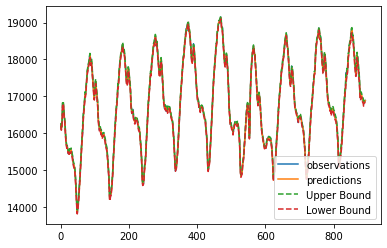

In [53]:
import numpy as np
plt.plot( df['coa'], '-',label = 'observations')
plt.plot( df['prediction'],'-', label = 'predictions')
plt.plot( df['ub'], '--',label = 'Upper Bound')
plt.plot(df['lb'], '--',label = 'Lower Bound')
# plt.plot(df['time'], df['var'],'--', label = 'latent variance', alpha = 0.4)
plt.legend()

In [57]:
df = pd.read_csv('coa_q_test.csv')
df['Time'] = pd.to_datetime(df['Time'], format = '%d/%m/%Y %H:%M')

prediction = []
prediction = pd.read_sql_query("select forecast_next('demand', 'coa', 'time' ,'pindex_test',averaging => 'last1',ahead => 4*24);", conn).values


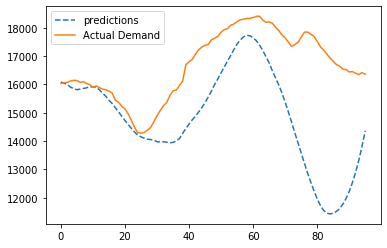

In [58]:
y = df['COA'].values[:len(prediction)]
plt.plot(prediction[:], '--', label = 'predictions')
plt.plot(y[:], label = 'Actual Demand')
plt.legend()

In [59]:
import numpy as np
100*np.mean(np.abs(y[:]-prediction[:])/y[:])

13.14963166513992

In [34]:
prediction = []
conn = psycopg2.connect(conn_string)
insert = "insert into demand values ('%s', %s)"
for i in df.values[:200]:
    print(i)
    prediction.append(pd.read_sql_query("select forecast_next ('demand', 'coa', 'time' ,'pindex_test', ahead => 1);", conn).values[0][0])
    cursor = conn.cursor()
    cursor.execute(insert %(i[0], i[1]))
    conn.commit()
    conn.close()
    conn = psycopg2.connect(conn_string)

[Timestamp('2019-08-21 00:00:00') 16032]
[Timestamp('2019-08-21 00:15:00') 16057]
[Timestamp('2019-08-21 00:30:00') 16071]
[Timestamp('2019-08-21 00:45:00') 16118]
[Timestamp('2019-08-21 01:00:00') 16144]
[Timestamp('2019-08-21 01:15:00') 16134]
[Timestamp('2019-08-21 01:30:00') 16072]
[Timestamp('2019-08-21 01:45:00') 16095]
[Timestamp('2019-08-21 02:00:00') 16032]
[Timestamp('2019-08-21 02:15:00') 15989]
[Timestamp('2019-08-21 02:30:00') 15890]
[Timestamp('2019-08-21 02:45:00') 15948]
[Timestamp('2019-08-21 03:00:00') 15885]
[Timestamp('2019-08-21 03:15:00') 15832]
[Timestamp('2019-08-21 03:30:00') 15809]
[Timestamp('2019-08-21 03:45:00') 15763]
[Timestamp('2019-08-21 04:00:00') 15690]
[Timestamp('2019-08-21 04:15:00') 15437]
[Timestamp('2019-08-21 04:30:00') 15366]
[Timestamp('2019-08-21 04:45:00') 15222]
[Timestamp('2019-08-21 05:00:00') 15133]
[Timestamp('2019-08-21 05:15:00') 14958]
[Timestamp('2019-08-21 05:30:00') 14723]
[Timestamp('2019-08-21 05:45:00') 14474]
[Timestamp('2019

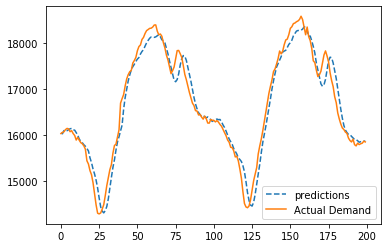

In [35]:
y = df['COA'].values[:len(prediction)]
plt.plot(prediction[:], '--', label = 'predictions')
plt.plot(y[:], label = 'Actual Demand')
plt.legend()

In [37]:
100*np.mean(np.abs(y[:]-prediction[:])/y[:])

1.2423324956111204